In [1]:
# !git clone https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

In [2]:
import os
import time
import subprocess
import numpy as np
import pandas as pd
import ast
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from scheduler import GradualWarmupScheduler
import albumentations
import torch.cuda.amp as amp
import segmentation_models_pytorch as smp
from tqdm import tqdm as tqdm
import glob
scaler = amp.GradScaler()
device = torch.device('cuda')
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [3]:
DEBUG = False
kernel_type = 'unet++b1_2cbce_1024T15tip_lr1e4_bs4_augv2_30epo'
enet_type = 'efficientnet-b3'
mask_dir = '../../Humpback-Whale-Identification-1st-/input/masks' 
data_dir = '../../train' 
num_workers = 16
image_size = 512
batch_size = 4
init_lr = 1e-4
warmup_epo = 1
# If DEBUG == True, only run 3 epochs per fold
cosine_epo = 9 if not DEBUG else 2
n_epochs = warmup_epo + cosine_epo
use_amp = True
image_folder = 'train'

log_dir = '../logs_seg'
model_dir = '../models_seg'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
log_file = os.path.join(log_dir, f'log_{kernel_type}.txt')

In [4]:
class SegDataset(Dataset):

    def __init__(self, data,mask_dir,data_dir, mode, transform=None):

        self.data = data
        self.mode = mode
        self.transform = transform
        self.data_dir = data_dir
        self.mask_dir = mask_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data[index]
        image = cv2.imread(os.path.join(self.data_dir,row))[:, :, ::-1]

        if self.mode == 'test':
            mask = None
            res = self.transform(image=image)
        else:
            mask = cv2.imread(os.path.join(self.mask_dir ,row))[:, :, ::-1]
            mask = cv2.resize(mask ,(image_size, image_size)).astype(float)
            mask = (mask > 0.5).astype(np.uint8)[:,:,1:2]
            res = self.transform(image=image, mask=mask)

        image = res['image'].astype(np.float32).transpose(2, 0, 1) / 255.

        if self.mode == 'test':
            return torch.tensor(image)
        else:
            mask = res['mask'].astype(np.float32)
            mask = mask.transpose(2, 0, 1).clip(0, 1)
            return torch.tensor(image), torch.tensor(mask)

In [5]:
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),                                    
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightness(limit=0.1, p=0.75),
    albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, border_mode=0, p=0.75),
    albumentations.Cutout(max_h_size=int(image_size * 0.3), max_w_size=int(image_size * 0.3), num_holes=1, p=0.75),
])
transforms_val = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
])

/home/kaor/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/home/kaor/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


In [6]:
dataset_show = SegDataset(os.listdir(f"{mask_dir}"),mask_dir,data_dir, 'train', transform=transforms_train)

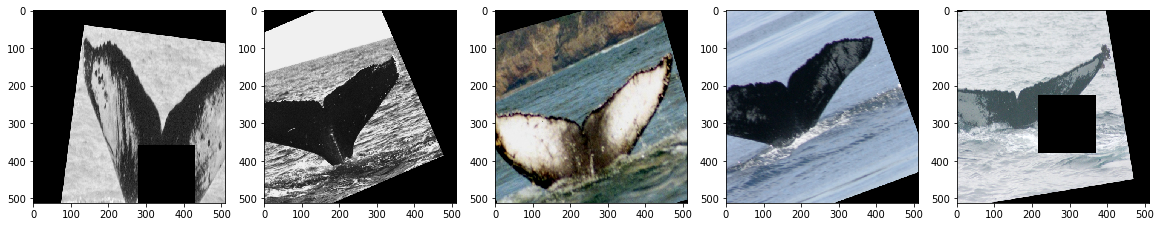

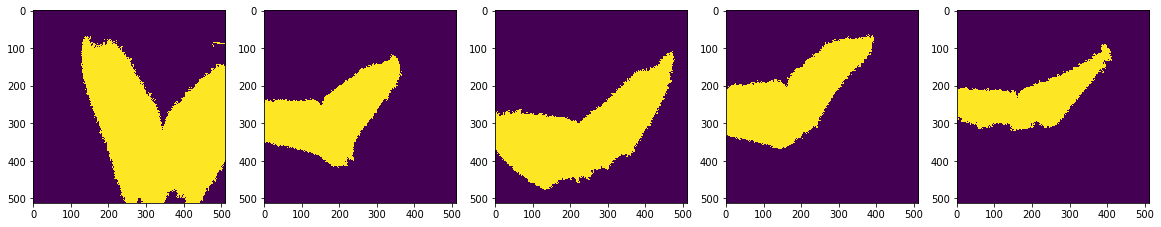

In [7]:
f, axarr = plt.subplots(1,5)
masks = []
for p in range(5):
    img, mask = dataset_show[p]
    img[0] = img[0]
    axarr[p].imshow(img.transpose(0, 1).transpose(1,2))
    masks.append(mask)

f, axarr = plt.subplots(1,5)
for p in range(5):
    axarr[p].imshow(masks[p][0])

In [8]:
# !mv efficientnet-b3-5fb5a3c3.pth /home/kaor/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth

In [9]:
class SegModel(nn.Module):
    def __init__(self, backbone):
        super(SegModel, self).__init__()
        self.seg = smp.Unet(encoder_name=backbone, encoder_weights='imagenet', classes=1)
    def forward(self,x):
        global_features = self.seg.encoder(x)
        seg_features = self.seg.decoder(*global_features)
        seg_features = self.seg.segmentation_head(seg_features)
        return seg_features
    
with torch.no_grad():
    m = SegModel(enet_type)
    m(torch.rand(2,3,224,224)).shape

In [10]:
criterion = nn.BCEWithLogitsLoss()

/home/kaor/.local/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/kaor/.local/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use cas

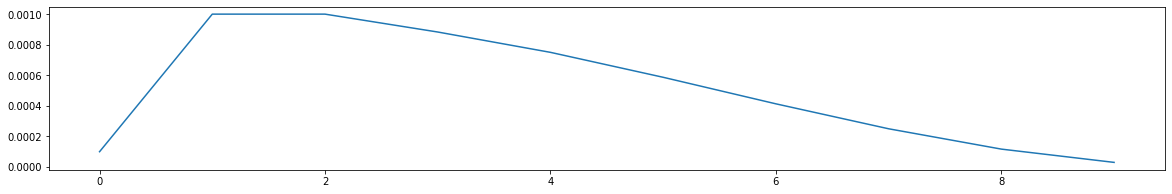

In [11]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

optimizer = optim.Adam(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_warmup.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
rcParams['figure.figsize'] = 20,3
plt.plot(lrs)

In [12]:
def train_epoch(model, loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, mask) in bar:

        optimizer.zero_grad()
        data, mask = data.to(device), mask.to(device)

        with amp.autocast():
            logits = model(data)
            loss = criterion(logits, mask)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_np = loss.item()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-50:]) / min(len(train_loss), 50)
        bar.set_description('loss: %.4f, smth: %.4f' % (loss_np, smooth_loss))

    return np.mean(train_loss)


def valid_epoch(model, loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    with torch.no_grad():
        for (data, mask) in tqdm(loader):
            data, mask = data.to(device), mask.to(device)
            logits = model(data)
            loss = criterion(logits, mask)
            val_loss.append(loss.item())
            LOGITS.append(logits.cpu())

    if get_output:
        LOGITS = torch.cat(LOGITS, 0).float().sigmoid()
        return LOGITS
    else:
        val_loss = np.mean(val_loss)
        return val_loss

In [13]:
def run(fold):
    content = 'Fold: ' + str(fold)
    print(content)
    with open(log_file, 'a') as appender:
        appender.write(content + '\n')
    train_ = os.listdir(f"{mask_dir}")
    valid_ = train_[0:50]
    train_ = train_[50:]

    dataset_train = SegDataset(train_,mask_dir,data_dir, 'train', transform=transforms_train)
    dataset_valid = SegDataset(valid_,mask_dir,data_dir, 'valid', transform=transforms_val)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = SegModel(enet_type)
    model = model.to(device)
    val_loss_min = np.Inf
    model_file = os.path.join(model_dir, f'{kernel_type}_best_fold{fold}.pth')

    optimizer = optim.Adam(model.parameters(), lr=init_lr)
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
    scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)
        scheduler_warmup.step(epoch-1)

        train_loss = train_epoch(model, train_loader, optimizer)
        val_loss = valid_epoch(model, valid_loader)

        content = time.ctime() + ' ' + f'Fold {fold} Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {(val_loss):.5f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if val_loss_min > val_loss:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min, val_loss))
            torch.save(model.state_dict(), model_file)
            val_loss_min = val_loss
    return model

In [14]:
for fold in range(1):
    model = run(fold)

Fold: 0


  0%|          | 0/100 [00:00<?, ?it/s]

Thu Feb 24 18:12:19 2022 Epoch: 1


100%|██████████| 13/13 [00:02<00:00,  4.51it/s]


Thu Feb 24 18:12:46 2022 Fold 0 Epoch 1, lr: 0.0001000, train loss: 0.55890, valid loss: 0.34907.
Validation loss decreased (inf --> 0.349072).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

Thu Feb 24 18:12:46 2022 Epoch: 2


100%|██████████| 13/13 [00:02<00:00,  4.60it/s]


Thu Feb 24 18:13:13 2022 Fold 0 Epoch 2, lr: 0.0010000, train loss: 0.19266, valid loss: 0.11369.
Validation loss decreased (0.349072 --> 0.113690).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

Thu Feb 24 18:13:13 2022 Epoch: 3


100%|██████████| 13/13 [00:02<00:00,  4.57it/s]


Thu Feb 24 18:13:41 2022 Fold 0 Epoch 3, lr: 0.0010000, train loss: 0.11311, valid loss: 0.06144.
Validation loss decreased (0.113690 --> 0.061437).  Saving model ...
Thu Feb 24 18:13:41 2022 Epoch: 4


100%|██████████| 13/13 [00:02<00:00,  4.63it/s]


Thu Feb 24 18:14:09 2022 Fold 0 Epoch 4, lr: 0.0008830, train loss: 0.08586, valid loss: 0.05375.
Validation loss decreased (0.061437 --> 0.053754).  Saving model ...
Thu Feb 24 18:14:09 2022 Epoch: 5


100%|██████████| 13/13 [00:02<00:00,  4.73it/s]


Thu Feb 24 18:14:36 2022 Fold 0 Epoch 5, lr: 0.0007500, train loss: 0.07399, valid loss: 0.04911.
Validation loss decreased (0.053754 --> 0.049108).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

Thu Feb 24 18:14:37 2022 Epoch: 6


100%|██████████| 13/13 [00:02<00:00,  4.62it/s]


Thu Feb 24 18:15:04 2022 Fold 0 Epoch 6, lr: 0.0005868, train loss: 0.05852, valid loss: 0.04335.
Validation loss decreased (0.049108 --> 0.043353).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

Thu Feb 24 18:15:04 2022 Epoch: 7


100%|██████████| 13/13 [00:02<00:00,  4.59it/s]


Thu Feb 24 18:15:31 2022 Fold 0 Epoch 7, lr: 0.0004132, train loss: 0.05174, valid loss: 0.04249.
Validation loss decreased (0.043353 --> 0.042492).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

Thu Feb 24 18:15:31 2022 Epoch: 8


100%|██████████| 13/13 [00:02<00:00,  4.72it/s]


Thu Feb 24 18:15:58 2022 Fold 0 Epoch 8, lr: 0.0002500, train loss: 0.04918, valid loss: 0.04088.
Validation loss decreased (0.042492 --> 0.040878).  Saving model ...


  0%|          | 0/100 [00:00<?, ?it/s]

Thu Feb 24 18:15:59 2022 Epoch: 9


  0%|          | 0/100 [00:00<?, ?it/s]

Thu Feb 24 18:16:26 2022 Fold 0 Epoch 9, lr: 0.0001170, train loss: 0.04639, valid loss: 0.04135.
Thu Feb 24 18:16:26 2022 Epoch: 10


100%|██████████| 13/13 [00:02<00:00,  4.62it/s]


Thu Feb 24 18:16:54 2022 Fold 0 Epoch 10, lr: 0.0000302, train loss: 0.04668, valid loss: 0.04042.
Validation loss decreased (0.040878 --> 0.040423).  Saving model ...


In [16]:
dataset_test = SegDataset(os.listdir(data_dir),mask_dir,data_dir, 'test', transform=transforms_val)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

  0%|          | 0/6341 [00:00<?, ?it/s]

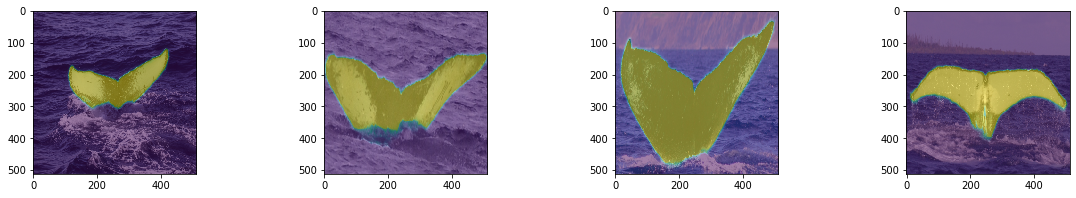

  0%|          | 0/6341 [00:03<?, ?it/s]


In [21]:
with torch.no_grad():
    for data in tqdm(test_loader):
        data = data.to(device)
        logits = model(data).sigmoid().cpu().numpy()[:,0]
        data = data.cpu().numpy().transpose(0,2,3,1)
        
        for i,(img,mask) in enumerate(zip(data,logits)):
            plt.subplot(1,4,i+1)
            plt.imshow(img)
            plt.imshow(mask,alpha=0.5)
        plt.show()
        break



In [20]:
len(data)

4